# Figure 3, Figure 4

In [1]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import pulp as p
from scipy import stats
import scipy as scipy
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker

In [2]:
# don't print warning messages
import warnings
warnings.filterwarnings('ignore')

In [3]:
def warburgModel(Glucose_Uptake_Rate, Y_Glyc, Y_Resp, V_Resp, V_Glyc, Mass_Fract_ATP, organism):
    
    '''The Warburg Model primary function is this publication. The function utilizes the analytical solution to 
    maximize the ATP production rate (umol ATP per mg cellular protein per min) 
    by assigning the functional fraction of fermentation and respiration in the ATP-producing proteome.
    
    The inputs into the model are:
    (1) glucose glucose uptake rate (umol glucose per mg cellular protein per min)- Glucose_Uptake_Rate
    (2) ATP Yield per molecule of glucose for fermentation and respiation - Y_Glyc & Y_Resp
    (3) Specific activity of fermentation and respiation (umol per mg pathway protein per min) - V_Resp & V_Glyc
    (4) Fraction of the proteome for ATP-producing enzymes - Mass_Fract_ATP
    
    The outputs of the function are:
    (1) Functional proteome occupancy of fermentation and respiration -  Mass_Fract_Glyc & Mass_Fract_Resp
    (2) Maximal ATP production rate - ATP production rate (umol per mg cellular protein per min)
    (3) Rate of fermentation and respiration that produce the maximal ATP production rate - Lact_rate & Resp_rate (umol per mg cellular protein per min)'''

    if V_Glyc * Y_Glyc > V_Resp * Y_Resp and V_Glyc * Mass_Fract_ATP <= Glucose_Uptake_Rate:
        #print(1)
        Mass_Fract_Glyc = max(0, Mass_Fract_ATP)
        Mass_Fract_Resp = 0
    elif V_Glyc * Y_Glyc < V_Resp * Y_Resp and V_Resp * Mass_Fract_ATP <= Glucose_Uptake_Rate:
        #print(2)
        Mass_Fract_Glyc = 0
        Mass_Fract_Resp = max(0, Mass_Fract_ATP)
    elif Y_Glyc > Y_Resp and V_Glyc * Mass_Fract_ATP >= Glucose_Uptake_Rate:
        #print(3)
        Mass_Fract_Glyc = max(0, Glucose_Uptake_Rate / V_Glyc)
        Mass_Fract_Resp = 0
    elif Y_Glyc < Y_Resp and V_Resp * Mass_Fract_ATP >= Glucose_Uptake_Rate:
        #print(4)
        Mass_Fract_Glyc = 0
        Mass_Fract_Resp = max(0, Glucose_Uptake_Rate / V_Resp)
    else: 
        #print(5)
        Mass_Fract_Glyc = max(0, (Mass_Fract_ATP * V_Resp - Glucose_Uptake_Rate) / (V_Resp-V_Glyc))
        Mass_Fract_Resp = max(0, (Glucose_Uptake_Rate - Mass_Fract_ATP * V_Glyc) / (V_Resp-V_Glyc))

    ATP_rate = Y_Glyc * V_Glyc * Mass_Fract_Glyc + Y_Resp * V_Resp * Mass_Fract_Resp 
    if organism == 'ecoli': 
        
        #Calculation of Acetate Production and Oxygen Consumption Rates
        #Note the a seperate calculation in in necessary for E. coli since Acetate Respiration Consumes Oxygen
        Lact_rate = 2 * p.value(Mass_Fract_Glyc) * V_Glyc
        Resp_rate = 6 * p.value(Mass_Fract_Resp) * V_Resp + p.value(Mass_Fract_Glyc) * 2 * V_Glyc
    
    else:  
        
        #Calculation of Ethanol/Lactate Production and Oxygen Consumption Rates
        Lact_rate = 2 * p.value(Mass_Fract_Glyc) * V_Glyc
        Resp_rate = 6 * p.value(Mass_Fract_Resp) * V_Resp
    
    df = pd.DataFrame({'gluc' : [Glucose_Uptake_Rate], 
                       'glyc_mass' : [Mass_Fract_Glyc], 'resp_mass' : [Mass_Fract_Resp], 
                       'lact' : [Lact_rate], 'o2' : [Resp_rate]})
  
    # Printing the final solution
    return(Mass_Fract_Glyc, Mass_Fract_Resp, ATP_rate, Lact_rate, Resp_rate) 



In [4]:
def warburgLoop(rates, proteomics, ferm_proteomics, resp_proteomics, gly_proteomics, Y_Glyc, Y_Resp, min_gluc, max_gluc, organism): 
    
    '''Performs bootstrapping to resample the five parameter estimates (i.e. fraction of 
    the proteome occupied by pathway, specific activity, and ATP yield) with replacement (N=10,000). 
    After each round of sampling, the specific activity of each pathway is calculated. The sampled 
    parameter values for proteome occupied by pathway, specific activity, and ATP yield from each 
    round of bootstrapping are used in the linear program described in the function above. 
    All 10,000 results are stored in a data frame, which in the output.'''

    results_final = []
    
       
    for j in tqdm(range(10000)):
        V_Resp = []
        V_Glyc = []
        Mass_Fract_ATP = []
    
        #random choice with replacement for each paramter 
        sample_activity_respiration = rates.loc[rates['pathway'] == 'Respiration', 'glucose uptake rate  (mmol gprotein-1 hr-1)'].unique() / 60
        #print(sample_activity_respiration)
        sample_activity_fermentation = rates.loc[rates['pathway'] == 'Fermentation', 'glucose uptake rate  (mmol gprotein-1 hr-1)'].unique() / 60
        #print(sample_activity_fermentation)
        sample_mass_respiraition = resp_proteomics.loc[(resp_proteomics['estimate'] == 'respiration'), 'value'].unique()
        #print(sample_mass_respiraition)
        sample_mass_fermentation = ferm_proteomics.loc[(ferm_proteomics['estimate'] == 'fermentation'), 'value'].unique()
        #print(sample_mass_fermentation)
        sample_mass_ATP = proteomics['value'].unique()
        sample_mass_glycolysis = gly_proteomics.loc[(gly_proteomics['estimate'] == 'fermentation'), 'value'].unique() 
        
        sample_size_activity_respiration = len(sample_activity_respiration)
        sample_size_activity_fermentation = len(sample_activity_fermentation)
        sample_size_mass_respiraition = len(sample_mass_respiraition)
        sample_size_mass_fermentation = len(sample_mass_fermentation)
        sample_size_mass_ATP = len(sample_mass_ATP)
        sample_size_mass_glycolysis= len(sample_mass_glycolysis)
    
        sample_specific_activity_fermentation = np.random.choice(sample_activity_fermentation, size=sample_size_activity_fermentation,replace=True)
        sample_specific_activity_respiration = np.random.choice(sample_activity_respiration, size=sample_size_activity_respiration, replace=True)
        sample_fraction_fermentation = np.random.choice(sample_mass_fermentation, size=sample_size_mass_fermentation, replace=True)
        sample_fraction_respiration = np.random.choice(sample_mass_respiraition, size=sample_size_mass_respiraition, replace=True)
        sample_fraction_ATP = np.random.choice(sample_mass_ATP, size=sample_size_mass_ATP, replace=True)
        sample_fraction_glycolysis = np.random.choice(sample_mass_glycolysis, size=sample_size_mass_glycolysis, replace=True)
        
        #calculate model parameters for current bootstrap iteration   
        V_Resp =  sample_specific_activity_respiration.mean() / (sample_fraction_respiration.mean())
        #print(V_Resp)
        V_Glyc = sample_specific_activity_fermentation.mean() / sample_fraction_fermentation.mean() 
        #print(V_Glyc)
        #print(sample_specific_activity_fermentation.mean())
        
        V_Glyc_2 = sample_specific_activity_fermentation.mean() / sample_fraction_glycolysis.mean() 
        
        rate_ratio = V_Resp / V_Glyc_2
        
        V_Resp =  sample_specific_activity_respiration.mean() / (sample_fraction_respiration.mean() + sample_fraction_glycolysis.mean() * rate_ratio)

        #print(V_Glyc)
        #print(V_Resp)
        
        Mass_Fract_ATP = sample_fraction_ATP.mean() 
        #print(Mass_Fract_ATP)
        Y_Glyc = Y_Glyc
        Y_Resp = Y_Resp
        
        #glucose uptake rates to loop through 
        gluc = np.linspace(min_gluc, max_gluc, 200)
        
        #Empty arrays to save results
        glucose_uptake = []
        glyc_mass = []
        resp_mass = []
        atp = []
        lact = []
        o2 = []
    
        #loop through the linear model for each glucose uptake rate
        for i in range(len(gluc)):
            loop_result = (warburgModel(gluc[i], Y_Glyc, Y_Resp, V_Resp, V_Glyc, Mass_Fract_ATP, organism)) 
            #print(loop_result)
            
            glyc_mass.append(loop_result[0])
            resp_mass.append(loop_result[1])
            atp.append(loop_result[2])
            lact.append(loop_result[3])
            o2.append(loop_result[4])
            glucose_uptake.append(gluc[i])
            
        results = [glyc_mass, resp_mass, atp, lact, o2, glucose_uptake]
        
        #Append the outputs for each bootstrap iteration
        results_final.append(results)
    
    #Convert the array into a dataframe
    df = pd.DataFrame({'gluc' : [], 'glyc_mass' : [], 'resp_mass' : [], 'atp' : [], 'lact' : [], 'o2' : []})

    for i in range(len(results_final)):
        df_temp_gluc = pd.DataFrame({'gluc' : results_final[i][5]})
        df_temp_gly = pd.DataFrame({'glyc_mass' : results_final[i][0]})
        df_temp_resp = pd.DataFrame({'resp_mass' : results_final[i][1]})
        df_temp_atp = pd.DataFrame({'atp' : results_final[i][2]})
        df_temp_lac = pd.DataFrame({'lact' : results_final[i][3]})
        df_temp_o2 = pd.DataFrame({'o2' : results_final[i][4]})
        out = df_temp_gluc.join([df_temp_gly, df_temp_resp, df_temp_atp, df_temp_lac, df_temp_o2])
        
        df = pd.concat([df, out])
        
    return(df)

In [5]:
def warburgCI(df): 
    
    '''Calculates the 95 confidence interval for each output of the model'''

    df_sub = df[['glyc_mass', 'resp_mass', 'atp', 'lact', 'o2']]

    df_95_low = pd.DataFrame(np.array(df['gluc'].unique()), columns=['gluc'])
    df_95_high = pd.DataFrame(np.array(df['gluc'].unique()), columns=['gluc'])

    for column in list(df_sub.columns): 
        df_temp = df_sub[[column]]
        df_temp = pd.concat([df[['gluc']],df_temp],axis=1)
        #print(df_temp)
        column_names = ['gluc', column]
        df_95_temp_low = pd.DataFrame(columns = column_names)
        df_95_temp_high = pd.DataFrame(columns = column_names)
        for gluc_uptake in list(df_temp['gluc'].unique()):
        #print(gluc_uptake)
            sample = np.array(df_temp.loc[df_temp['gluc'] == gluc_uptake, column])
            #mean, sigma = np.mean(sample), np.std(sample)
            #conf_int = stats.norm.interval(0.95, loc=mean, scale=sigma)
            #confidence95 = mean - conf_int[0]
            sample_count = len(sample)
            sample_high = sample_count * .975
            sample_low = sample_count * .025
            sample = np.sort(sample)
            conf95_high = sample[int(sample_high) - 1]
            conf95_low = sample[int(sample_low) - 1]
            data_low = {'gluc': [gluc_uptake], column: [conf95_low]}
            data_high = {'gluc': [gluc_uptake], column: [conf95_high]}
            data_low_df = pd.DataFrame(data_low)
            data_high_df = pd.DataFrame(data_high)
            df_95_temp_low = df_95_temp_low.append(data_low_df)
            df_95_temp_high = df_95_temp_high.append(data_high_df)
        df_95_low = df_95_low.merge(df_95_temp_low, on='gluc')
        df_95_high = df_95_high.merge(df_95_temp_high, on='gluc')
    df_95 = pd.merge(df_95_low, df_95_high, on = 'gluc', how = 'left')
    
    return(df_95)    

## Figure 3 A & D
### Model estimates for *E. coli*

In [6]:
#parameter estimates for proteome occupany
proteomics = pd.read_csv('./Data/2024_02_22_ecoli_atp_total.csv')

#parameters estimates for specfic activity
rates = pd.read_csv('./Data/ecoli_cellular_rates.csv')

#parameters estimates for specfic activity proteome
ferm_proteomics = pd.read_csv('./Data/2024_02_22_ecoli_specific_activity_fermentation.csv')
resp_proteomics = pd.read_csv('./Data/2024_02_22_ecoli_specific_activity_respiration.csv')

In [7]:
#data into warburgLoop function
ecoli_model = warburgLoop(rates, proteomics, ferm_proteomics, resp_proteomics, ferm_proteomics, 10, 20, 0.1/ 60, 10.5/ 60, 'ecoli')

  0%|          | 0/10000 [00:00<?, ?it/s]

In [8]:
#Calculate confidence interval 
ecoli_model_conf = warburgCI(ecoli_model)
max_conf = np.array(ecoli_model_conf['lact_x'])
min_conf = np.array(ecoli_model_conf['lact_y'])
ecoli_min = next(i for i, x in enumerate(min_conf) if x > 0)
ecoli_max = next(i for i, x in enumerate(max_conf) if x > 0)

In [9]:
#reset index
ecoli_model_mean = ecoli_model.groupby('gluc').median().reset_index()

In [10]:
#experimental values (points on figs below) to compare to model predictions
ecoli_experiments = pd.read_csv('./Data/ecoli_experimental.csv')

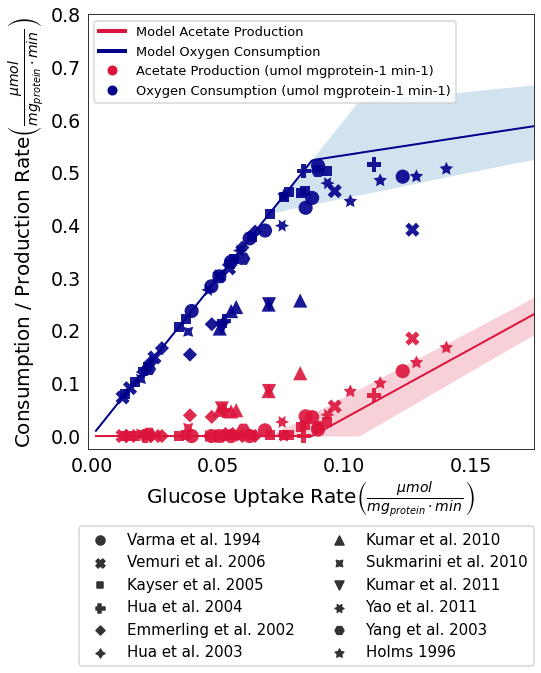

In [11]:
#Plot Figure 3a
#Model predictions of fermentation and respiration rates in E. coli

fig, ax = plt.subplots(figsize=(8,8))
ax.patch.set_facecolor('white')
sns.set_context("talk")

#plot model predictions 
ax.plot(ecoli_model_mean['gluc'], ecoli_model_mean['lact'], color = 'crimson', linewidth = 2, label='Model Acetate Production')
ax.fill_between(ecoli_model_mean['gluc'], ecoli_model_conf['lact_y'], ecoli_model_conf['lact_x'], color = 'crimson', alpha=0.2, linewidth = 0)
ax.plot(ecoli_model_mean['gluc'], ecoli_model_mean['o2'], color = 'darkblue', linewidth = 2, label='Model Oxygen Consumption')
ax.fill_between(ecoli_model_mean['gluc'], ecoli_model_conf['o2_y'], ecoli_model_conf['o2_x'], alpha=0.2, linewidth = 0)

#plot experimental data
glyc = sns.scatterplot(ecoli_experiments['Glucose Consumption (mmol gprotein-1 hr-1)']/ 60, ecoli_experiments['Acetate Production (mmol gprotein-1 hr-1)']/ 60, color = 'crimson', alpha=.9, label='Experimental Acetate Production', linewidth = 0, s=200, zorder = 3, style = ecoli_experiments['Author'])
sns.scatterplot(ecoli_experiments['Glucose Consumption (mmol gprotein-1 hr-1)']/ 60, ecoli_experiments['Oxygen Consumption (mmol gprotein-1 hr-1)']/ 60, color = 'darkblue', alpha=.9, label='Experimental Oxygen Consumption', linewidth = 0, s=200, zorder = 4, style = ecoli_experiments['Author'])

#axis format
ax.set_xlabel("Glucose Uptake Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=20)
ax.set_ylabel("Consumption / Production Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=19, left=False, bottom=False)
ax.set_xlim(-1/ 600, ecoli_model_conf['gluc'].max())
ax.set_ylim(-1/ 40, 0.8)

#legend format 
custom = [Line2D([0], [0], color='crimson', lw=4),
          Line2D([0], [0], color='darkblue', lw=4),
          Line2D([], [], marker='o', color='crimson', linestyle='None'),
          Line2D([], [], marker='o', color='darkblue', linestyle='None')]
ax.add_artist(plt.legend(custom, ['Model Acetate Production', 'Model Oxygen Consumption', 'Acetate Production (umol mgprotein-1 min-1)', 'Oxygen Consumption (umol mgprotein-1 min-1)'], fontsize = 13, loc='upper left'))

h,l = glyc.get_legend_handles_labels()
l1 = glyc.legend(h[3:15],l[3:15], loc='upper center', bbox_to_anchor=(0.49, -0.16), fontsize = 15, ncol=2)


#save fig
fig.savefig('./Figures/fig3a_ecoli_rate_predictions.svg',format='svg', dpi=1200)


## Model Estimates for *S. cerevisiae*

In [12]:
#parameter estimates for proteome occupany
proteomics = pd.read_csv('./Data/2024_02_25_yeast_atp_total_core.csv')

#parameters estimates for specfic activity
rates = pd.read_csv('./Data/yeast_cellular_rates.csv')

#parameters estimates for specfic activity proteome
resp_proteomics = pd.read_csv('./Data/2024_02_25_yeast_specific_activity_resp_core.csv')
ferm_proteomics = pd.read_csv('./Data/2024_02_25_yeast_specific_activity_fermentation.csv')

In [13]:
#data into warburgLoop function
yeast_model = warburgLoop(rates, proteomics, ferm_proteomics, resp_proteomics, ferm_proteomics, 2, 16, 0.1/60, 39/60, 'yeast')

  0%|          | 0/10000 [00:00<?, ?it/s]

In [14]:
#calculate confidence interval 
yeast_model_conf = warburgCI(yeast_model)

In [15]:
#reset index
yeast_model_mean = yeast_model.groupby('gluc').median().reset_index()

In [16]:
#experimental values (points on figs below) to compare to model predictions
yeast_experiments = pd.read_csv('./Data/yeast_experimental.csv')

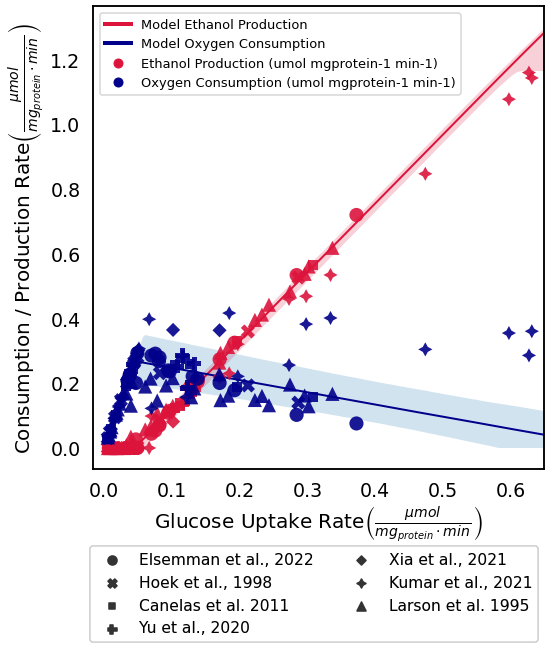

In [17]:
#Plot Figure 3b
#Model predictions of fermentation and respiration rates in S. cerevisiae
fig, ax = plt.subplots(figsize=(8,8))
ax.patch.set_facecolor('white')
sns.set_context("talk")

#plot model predictions 
ax.plot(yeast_model_mean['gluc'], yeast_model_mean['lact'], color = 'crimson', linewidth = 2, label='Model Ethanol Production')
ax.fill_between(yeast_model_mean['gluc'], yeast_model_conf['lact_y'], yeast_model_conf['lact_x'], color = 'crimson', alpha=0.2, linewidth = 0)
ax.plot(yeast_model_mean['gluc'], yeast_model_mean['o2'], color = 'darkblue', linewidth = 2, label='Model Oxygen Consumption')
ax.fill_between(yeast_model_mean['gluc'],yeast_model_conf['o2_y'], yeast_model_conf['o2_x'], alpha=0.2, linewidth = 0)

#plot experimental data
glyc = sns.scatterplot(yeast_experiments['Glucose Consumption (mmol gprotein-1 hr-1)']/60, yeast_experiments['Ethanol Production (mmol gprotein-1 hr-1)']/60, color = 'crimson', alpha=.9, label='Experimental Ethanol Production', linewidth = 0, s=200, zorder = 3, style = yeast_experiments['Author'])
sns.scatterplot(yeast_experiments['Glucose Consumption (mmol gprotein-1 hr-1)']/60, yeast_experiments['Oxygen Consumption (mmol gprotein-1 hr-1)']/60, color = 'darkblue', alpha=.9, label='Experimental Oxygen Consumption', linewidth = 0, s=200, zorder = 4, style = yeast_experiments['Author'])

#sns.scatterplot(yeast_experiments_sugar['Glucose Uptake Rate']/60, yeast_experiments_sugar['qEtOH']/60, color = 'crimson', alpha=.9, label='Experimental Ethanol Production', linewidth = 0, s=200, zorder = 3, style = yeast_experiments['Author'])
#sns.scatterplot(yeast_experiments_sugar['Glucose Uptake Rate']/60, yeast_experiments_sugar['qO2']/60, color = 'darkblue', alpha=.9, label='Experimental Oxygen Consumption', linewidth = 0, s=200, zorder = 4, style = yeast_experiments['Author'])

#axis format
ax.set_xlabel("Glucose Uptake Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=20)
ax.set_ylabel("Consumption / Production Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=19, left=False, bottom=False)
ax.set_xlim(-1/60, yeast_model_conf['gluc'].max())


#legend format 
custom = [Line2D([0], [0], color='crimson', lw=4),
          Line2D([0], [0], color='darkblue', lw=4),
          Line2D([], [], marker='o', color='crimson', linestyle='None'),
          Line2D([], [], marker='o', color='darkblue', linestyle='None')]
ax.add_artist(plt.legend(custom, ['Model Ethanol Production', 'Model Oxygen Consumption', 'Ethanol Production (umol mgprotein-1 min-1)', 'Oxygen Consumption (umol mgprotein-1 min-1)'], fontsize = 13, loc='upper left'))



h,l = glyc.get_legend_handles_labels()
ax.add_artist(plt.legend(h[3:10],l[3:10], loc='upper center', bbox_to_anchor=(0.49, -0.15), fontsize = 15.5, ncol=2))
#ax.add_artist(plt.legend(h[3:10],l[3:10], loc='upper right', fontsize=13, bbox_to_anchor=(1.42, 1.015)))


plt.tight_layout()

#save figure
fig.savefig('./Figures/fig3b_yeast_rates_perdiction.svg',format='svg', dpi=1200)


## Model Estimates for Mammalian cells

In [18]:
#parameter estimates for proteome occupany
proteomics = pd.read_csv('./Data/2024_02_26_mammalian_atp_total_core.csv')

#parameters estimates for specfic activity
rate = pd.read_csv('./Data/mammalian_cellular_rates.csv')

#parameters estimates for specfic activity proteome
resp_proteomics = pd.read_csv('./Data/2024_02_26_mammalian_specific_actvity_resp_core.csv')
ferm_proteomics = pd.read_csv('./Data/2024_02_26_mammalian_specific_actvity_ferm.csv')

In [19]:
#data into warburgLoop function
mammalian_model = warburgLoop(rate, proteomics, ferm_proteomics, resp_proteomics, ferm_proteomics, 2, 24, 0.01/60, 2/60, 'human')

  0%|          | 0/10000 [00:00<?, ?it/s]

In [20]:
#calculate confidence interval 
mammalian_model_conf = warburgCI(mammalian_model)

In [21]:
#reset index
mammalian_model_mean = mammalian_model.groupby('gluc').median().reset_index()

In [22]:
#experimental values (points on figs below) to compare to model predictions
mammalian_experiments = pd.read_csv('./Data/mammalian_experimental.csv')

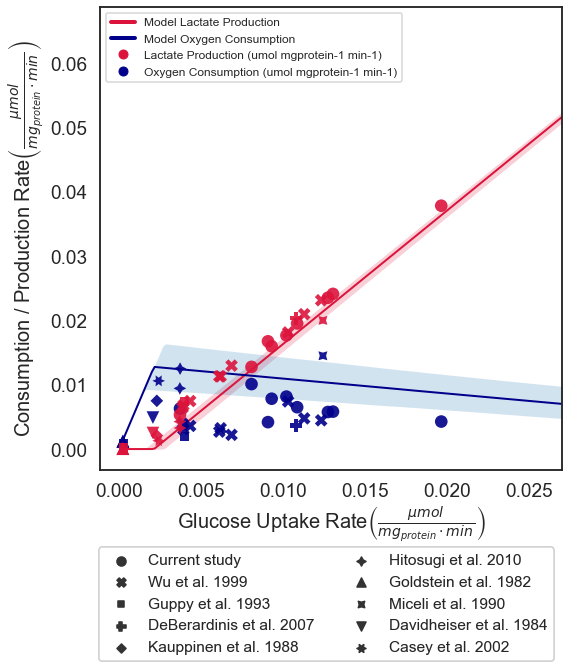

In [137]:
#Plot Figure 3c
#Model predictions of fermentation and respiration rates in mammalian cells
fig, ax = plt.subplots(figsize=(8.25,8))
ax.patch.set_facecolor('white')
sns.set_context("talk")

#plot model predictions 
ax.plot(mammalian_model_mean['gluc'], mammalian_model_mean['lact'], color = 'crimson', linewidth = 2, label='Model Lactate Production', zorder = 1)
ax.fill_between(mammalian_model_mean['gluc'], mammalian_model_conf['lact_y'], mammalian_model_conf['lact_x'], color = 'crimson', alpha=0.2, linewidth = 0)
ax.plot(mammalian_model_mean['gluc'], mammalian_model_mean['o2'], color = 'darkblue', linewidth = 2, label='Model Oxygen Consumption', zorder = 2)
ax.fill_between(mammalian_model_mean['gluc'], mammalian_model_conf['o2_y'], mammalian_model_conf['o2_x'], alpha=0.2, linewidth = 0)



#plot experimental data
glyc = sns.scatterplot(mammalian_experiments['Glucose Consumption (mmol gprotein-1 hr-1)']/60, mammalian_experiments['Lactate Production (mmol gprotein-1 hr-1)']/60, color = 'crimson', alpha=.9, label='Experimental Lactate Production', linewidth = 0, s=160, zorder = 4, style = mammalian_experiments['Author'])
sns.scatterplot(mammalian_experiments['Glucose Consumption (mmol gprotein-1 hr-1)']/60, mammalian_experiments['Oxygen Consumption (mmol gprotein-1 hr-1)']/60, color = 'darkblue', alpha=.9, label='Experimental Oxygen Consumption', linewidth = 0, s=160, zorder =3, style = mammalian_experiments['Author'])

#sns.scatterplot(mammalian_exp_nci60['gluc (umol mgprotein min-1)'], mammalian_exp_nci60['o2 (umol mgprotein min-1)'], color = 'teal', alpha=.9, label='Experimental Oxygen Consumption', linewidth = 0, s=160, zorder =3)
#sns.scatterplot(mammalian_exp_nci60['gluc (umol mgprotein min-1)'], mammalian_exp_nci60['lac (umol mgprotein min-1)'], color = 'coral', alpha=.9, label='Experimental Lactate Production', linewidth = 0, s=160, zorder = 4)


#axis format
ax.set_xlabel("Glucose Uptake Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=20)
ax.set_ylabel("Consumption / Production Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=19)
ax.set_xlim(-.07/60, .027)

#legend format 
custom = [Line2D([0], [0], color='crimson', lw=4),
          Line2D([0], [0], color='darkblue', lw=4),
          Line2D([], [], marker='o', color='crimson', linestyle='None'),
          Line2D([], [], marker='o', color='darkblue', linestyle='None')]
ax.add_artist(plt.legend(custom, ['Model Lactate Production', 'Model Oxygen Consumption', 'Lactate Production (umol mgprotein-1 min-1)', 'Oxygen Consumption (umol mgprotein-1 min-1)'], fontsize = 12, loc='upper left'))

h,l = glyc.get_legend_handles_labels()
ax.add_artist(plt.legend(h[3:13],l[3:13], loc='upper center', bbox_to_anchor=(0.49, -0.15), fontsize = 15.5, ncol=2))
#ax.add_artist(plt.legend(h[3:13],l[3:13], loc='upper right', fontsize=13, bbox_to_anchor=(1.43, 1.015)))


plt.tight_layout()

#save figure
fig.savefig('./Figures/fig3c_mammalian_rates_perdiction.svg',format='svg', dpi=1200)

## Figure 4
### Warburg Effect is independent of growth rate 

## *E. coli*

In [24]:
ecoli_experiments['Oxygen Consumption (umol mgprotein-1 min-1)'] = ecoli_experiments['Oxygen Consumption (mmol gprotein-1 hr-1)'] / 60 
ecoli_experiments['Acetate Production (umol mgprotein-1 min-1)'] = ecoli_experiments['Acetate Production (mmol gprotein-1 hr-1)'] / 60 
ecoli_experiments['Glucose Consumption (umol mgprotein-1 min-1)'] = ecoli_experiments['Glucose Consumption (mmol gprotein-1 hr-1)'] / 60 

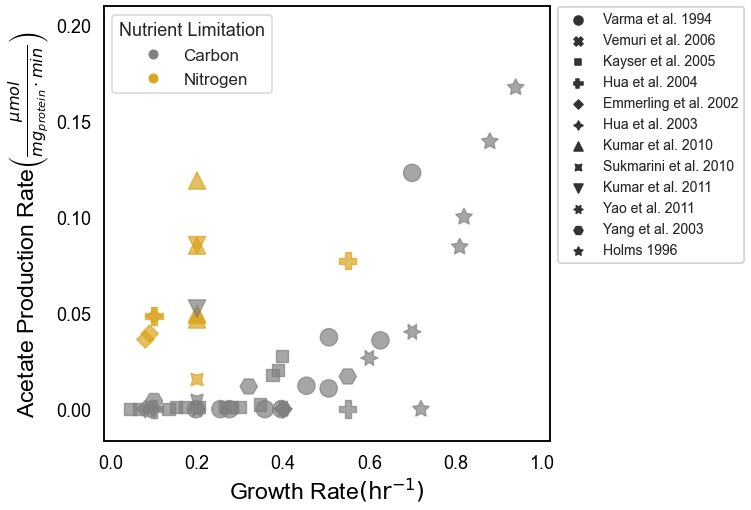

In [25]:
#Figure 4a
#Growth rate vs. acetate production in E. coli 

fig, ax = plt.subplots(figsize=(8,8))
ax.patch.set_facecolor('white')
sns.set_style("white")
sns.set_context("talk")
ax.tick_params(bottom=False, left=False)

#set color palette
palette = {"Carbon":"grey",
           "Nitrogen":"goldenrod", 
           "Phosphorous limited":"teal"}

#plot experimental data
glyc = sns.scatterplot(data=ecoli_experiments, x="Growth Rate", y="Acetate Production (umol mgprotein-1 min-1)",
                hue="Nutrient limitation", s=300, palette=palette, alpha=0.7, edgecolor = None, style = ecoli_experiments['Author'])

#axis format
ax.set_xlabel("Growth Rate" r'$ \left(\mathrm{hr}^{-1} \right)$', fontsize=23)
ax.set_ylabel("Acetate Production Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=23)
ax.tick_params(axis='both', which='major', labelsize=18)

#legend format
custom = [Line2D([], [], marker='o', color='grey', linestyle='None'),
          Line2D([], [], marker='o', color='goldenrod', linestyle='None')]
ax.add_artist(plt.legend(custom, ['Carbon', 'Nitrogen'], fontsize = 17, loc='upper left', title = 'Nutrient Limitation'))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_ylim(-1/60, 0.21)
ax.set_xlim(-1/60, 1.02)

h,l = glyc.get_legend_handles_labels()
ax.add_artist(plt.legend(h[4:20],l[4:20], loc='upper right', fontsize=14, bbox_to_anchor=(1.45, 1.015)))


#save fig 
fig.savefig('./Figures/figure4a_warburg_effect_growth.svg',format='svg', dpi=1200)

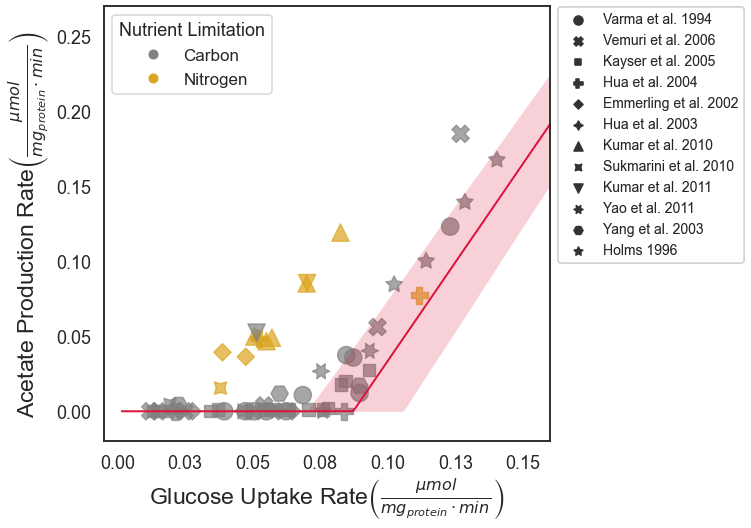

In [26]:
#Figure 4c
#Glucose uptake rate vs. acetate production in E. coli 

fig, ax = plt.subplots(figsize=(8,8))
ax.patch.set_facecolor('white')
sns.set_style("white")
sns.set_context("talk")
ax.tick_params(bottom=False, left=False)

#set color palette
palette = {"Carbon":"grey",
           "Nitrogen":"goldenrod", 
           "Phosphorous limited":"teal"}

#plot experimental data
sns.scatterplot(data=ecoli_experiments, x="Glucose Consumption (umol mgprotein-1 min-1)", y="Acetate Production (umol mgprotein-1 min-1)",
                hue="Nutrient limitation", s=300, palette=palette, alpha=0.7, edgecolor = None, style = ecoli_experiments['Author'])

ax.fill_between(ecoli_model_mean['gluc'], ecoli_model_conf['lact_y'], ecoli_model_conf['lact_x'], color = 'crimson', alpha=0.2, linewidth = 0)
#plot model preduction
ax.plot(ecoli_model_mean['gluc'], ecoli_model_mean['lact'], color = 'crimson', linewidth = 2, label='Model Acetate Production')
#ax.fill_between(ecoli_model['gluc'], ecoli_model['lact'] - ecoli_model_conf['lact'], ecoli_model['lact'] + ecoli_model_conf['lact'], color = 'crimson', alpha=0.2, linewidth = 0)

#axis format
ax.set_xlabel("Glucose Uptake Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=23)
ax.set_ylabel("Acetate Production Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=23)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xlim(-1/200, .16)
ax.set_ylim(-1/50, 0.27)
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

#legend format
custom = [Line2D([], [], marker='o', color='grey', linestyle='None'),
          Line2D([], [], marker='o', color='goldenrod', linestyle='None')]
ax.add_artist(plt.legend(custom, ['Carbon', 'Nitrogen'], fontsize = 17, loc='upper left', title = 'Nutrient Limitation'))

h,l = glyc.get_legend_handles_labels()
ax.add_artist(plt.legend(h[4:20],l[4:20], loc='upper right', fontsize=14, bbox_to_anchor=(1.45, 1.015)))


#save figure
fig.savefig('./Figures/figure4c_warburg_effect_glucose_uptake.svg',format='svg', dpi=1200)

In [27]:
#drop NA's from growth rate df
ecoli_experiments_corr = ecoli_experiments.dropna(subset=['Growth Rate'])
test1 = pd.to_numeric(ecoli_experiments_corr['Growth Rate'].values)
test2 = pd.to_numeric(ecoli_experiments_corr['Acetate Production (mmol gprotein-1 hr-1)'].values)
test3 = pd.to_numeric(ecoli_experiments_corr['Glucose Consumption (mmol gprotein-1 hr-1)'].values)

In [28]:
#Pearson correlation between growth rate and ethanol production rate
scipy.stats.pearsonr(test1, test2)

(0.5033643321806335, 7.675587966953621e-05)

In [29]:
#Pearson correlation between glucose uptake rate and acetate production rate
scipy.stats.pearsonr(test3, test2)

(0.6794239499280121, 8.559108357588252e-09)

## *S. cerevisiae*

In [30]:
yeast_experiments['Oxygen Consumption (umol mgprotein-1 min-1)'] = yeast_experiments['Oxygen Consumption (mmol gprotein-1 hr-1)'] / 60
yeast_experiments['Ethanol Production (umol mgprotein-1 min-1)'] = yeast_experiments['Ethanol Production (mmol gprotein-1 hr-1)'] / 60
yeast_experiments['Glucose Consumption (umol mgprotein-1 min-1)'] = yeast_experiments['Glucose Consumption (mmol gprotein-1 hr-1)'] / 60

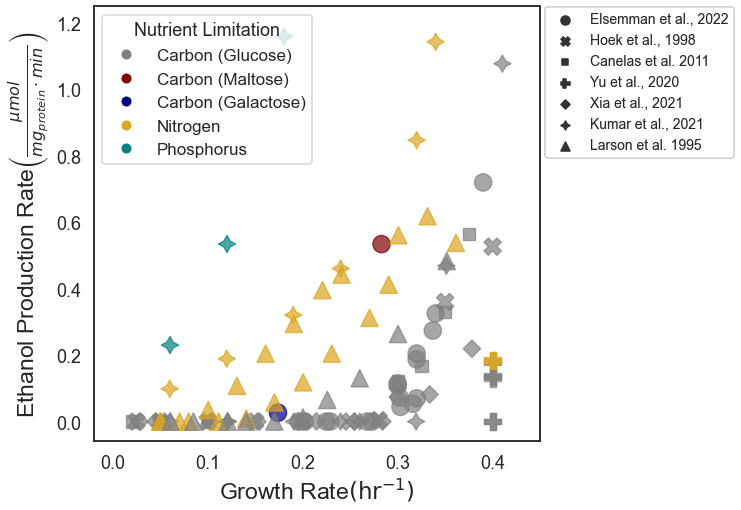

In [31]:
#Figure 4b 
#Growth rate vs. ethanol production in S. cerevisiae

fig, ax = plt.subplots(figsize=(8,8))
ax.patch.set_facecolor('white')
sns.set_style("white")
sns.set_context("talk")
ax.tick_params(bottom=False, left=False)

#set color palette
palette = {"Carbon":"grey",
           "Maltose":"#800000",
           "Galactose ":"navy",
           "Nitrogen":"goldenrod", 
           "Phosphorous":"teal"
           }

#plot experimental data
glyc = sns.scatterplot(data=yeast_experiments, x="Growth Rate (h_1)", y="Ethanol Production (umol mgprotein-1 min-1)",
                hue="Nutrient limitation", s=300, palette=palette, alpha=0.7, edgecolor = None, style = yeast_experiments['Author'])



#axis format
ax.set_xlabel("Growth Rate" r'$ \left(\mathrm{hr}^{-1} \right)$', fontsize=23)
ax.set_ylabel("Ethanol Production Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=23)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xlim(-1/50, 0.45)
ax.set_ylim(-1/17, 1.25)

#legend format
custom = [Line2D([], [], marker='o', color='grey', linestyle='None'),
          Line2D([], [], marker='o', color='#800000', linestyle='None'),
          Line2D([], [], marker='o', color='navy', linestyle='None'),
          Line2D([], [], marker='o', color='goldenrod', linestyle='None'),
          Line2D([], [], marker='o', color='teal', linestyle='None')]
ax.add_artist(plt.legend(custom, ['Carbon (Glucose)', 'Carbon (Maltose)', 'Carbon (Galactose)', 'Nitrogen', 'Phosphorus',], fontsize = 17, loc='upper left', title = 'Nutrient Limitation'))

h,l = glyc.get_legend_handles_labels()
ax.add_artist(plt.legend(h[7:int(len(h))],l[7:int(len(l))], loc='upper right', fontsize=14, bbox_to_anchor=(1.45, 1.015)))

#save figure
fig.savefig('./Figures/figure4c.svg',format='svg', dpi=1200)

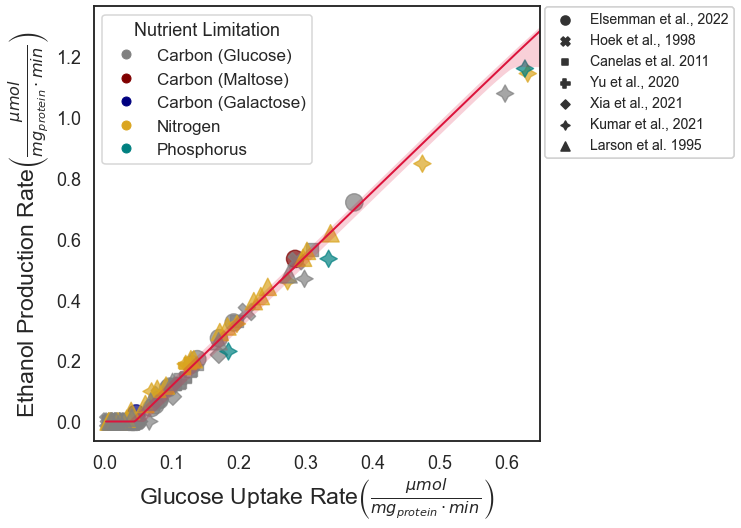

In [32]:
#Figure 4d 
#Glucose uptake rate vs. ethanol production in S. cerevisiae

fig, ax = plt.subplots(figsize=(8,8))
ax.patch.set_facecolor('white')
sns.set_style("white")
sns.set_context("talk")
ax.tick_params(bottom=False, left=False)

#set color palette
palette = {"Carbon":"grey",
           "Maltose":"#800000",
           "Galactose ":"navy",
           "Nitrogen":"goldenrod", 
           "Phosphorous":"teal"
           }

#plot experimental data
glyc = sns.scatterplot(data=yeast_experiments, x="Glucose Consumption (umol mgprotein-1 min-1)", y="Ethanol Production (umol mgprotein-1 min-1)",
                hue="Nutrient limitation", s=300, palette=palette, alpha=0.7, edgecolor = None, style = yeast_experiments['Author'])


#plot model predictions 
ax.plot(yeast_model_mean['gluc'], yeast_model_mean['lact'], color = 'crimson', linewidth = 2, label='Model Ethanol Production')
ax.fill_between(yeast_model_mean['gluc'], yeast_model_conf['lact_y'], yeast_model_conf['lact_x'], color = 'crimson', alpha=0.2, linewidth = 0)

#legend format
custom = [Line2D([], [], marker='o', color='grey', linestyle='None'),
          Line2D([], [], marker='o', color='#800000', linestyle='None'),
          Line2D([], [], marker='o', color='navy', linestyle='None'),
          Line2D([], [], marker='o', color='goldenrod', linestyle='None'),
          Line2D([], [], marker='o', color='teal', linestyle='None')]
ax.add_artist(plt.legend(custom, ['Carbon (Glucose)', 'Carbon (Maltose)', 'Carbon (Galactose)', 'Nitrogen', 'Phosphorus',], fontsize = 17, loc='upper left', title = 'Nutrient Limitation'))

#axis format
ax.set_xlabel("Glucose Uptake Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=23)
ax.set_ylabel("Ethanol Production Rate" r'$ \left(\frac{\mu mol}{mg_{protein} \cdot min^{}}\right)$', fontsize=23)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xlim(-1/60, yeast_model_conf['gluc'].max())

h,l = glyc.get_legend_handles_labels()
ax.add_artist(plt.legend(h[8:int(len(h))],l[8:int(len(l))], loc='upper right', fontsize=14, bbox_to_anchor=(1.45, 1.015)))

#ax.set_xlim(-1,26)
#ax.set_ylim(-1,45)

fig.savefig('./Figures/2022_08_25_figure4z.svg',format='svg', dpi=1200)

In [33]:
#drop NA's from growth rate df
yeast_experiments_corr = yeast_experiments.dropna(subset=['Growth Rate (h_1)'])
test1 = pd.to_numeric(yeast_experiments_corr['Growth Rate (h_1)'].values)
test2 = pd.to_numeric(yeast_experiments_corr['Ethanol Production (mmol gprotein-1 hr-1)'].values)
test3 = pd.to_numeric(yeast_experiments_corr['Glucose Consumption (mmol gprotein-1 hr-1)'].values)

In [34]:
#Pearson correlation between growth rate and ethanol production rate
scipy.stats.pearsonr(test1, test2)

(0.4264488286602443, 7.851961605777917e-06)

In [35]:
#Pearson correlation between glucose uptake rate and ethanol production rate
scipy.stats.pearsonr(test3, test2)

(0.9939865840464932, 7.008031287677656e-98)